L'objectif est d'appliquer un modèle de régression logistique sur les variables du "reduced model" de l'IMPACT score pour la prédiction de la survenue de complication liée au cathétérisme (CLAC).

1) charger les données
2) obtenir le format pour le notebook ecrf vers reduced model
3) appliquer une régression logistique
4) comparer aux résultats et faire l'aire sous la courbe

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

## Import données KT

In [2]:
df_KTTR = pd.read_csv('KTTR', sep = ";", encoding = "utf-8")
df_KTTR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5312 entries, 0 to 5311
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   IPP            5312 non-null   object 
 1   Date document  5312 non-null   object 
 2   sexe           4990 non-null   object 
 3   POIDS          4516 non-null   object 
 4   PTDGV          345 non-null    float64
 5   RVP            2 non-null      object 
 6   QPQS           42 non-null     object 
 7   PAPM           2897 non-null   float64
 8   PAPS           2550 non-null   float64
 9   SVO2           1165 non-null   float64
 10  SAT            45 non-null     float64
dtypes: float64(5), object(6)
memory usage: 456.6+ KB


## Ajout type de KT

In [3]:
df_tdk = pd.read_csv('TDK.csv', sep = ";", encoding = "utf-8")

# TDK : ne garder que la première regex
df_tdk.columns = ['IPP', 'DDDoc', 'TDK']
df_tdk['DDDoc']= pd.to_datetime(df_tdk['DDDoc'])
df_tdk['TDK1'], df_tdk['TDK2'] = df_tdk['TDK'].str.split(';', 1).str
df_tdk = df_tdk[['IPP', 'DDDoc', 'TDK1']]

df_tdk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11346 entries, 0 to 11345
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   IPP     11346 non-null  object        
 1   DDDoc   11346 non-null  datetime64[ns]
 2   TDK1    11346 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 266.0+ KB


C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [4]:
df_KTTR.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5312 entries, 0 to 5311
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   IPP            5312 non-null   object 
 1   Date document  5312 non-null   object 
 2   sexe           4990 non-null   object 
 3   POIDS          4516 non-null   object 
 4   PTDGV          345 non-null    float64
 5   RVP            2 non-null      object 
 6   QPQS           42 non-null     object 
 7   PAPM           2897 non-null   float64
 8   PAPS           2550 non-null   float64
 9   SVO2           1165 non-null   float64
 10  SAT            45 non-null     float64
dtypes: float64(5), object(6)
memory usage: 456.6+ KB


In [5]:
# Merger KTTR et TDK sur l'IPP avec un left-join sur KTTR
df = pd.merge(df_KTTR,
               df_tdk,
               left_on='IPP',
               right_on='IPP',
               how='left')

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28813 entries, 0 to 28812
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   IPP            28813 non-null  object        
 1   Date document  28813 non-null  object        
 2   sexe           28432 non-null  object        
 3   POIDS          24847 non-null  object        
 4   PTDGV          2492 non-null   float64       
 5   RVP            13 non-null     object        
 6   QPQS           185 non-null    object        
 7   PAPM           15353 non-null  float64       
 8   PAPS           11575 non-null  float64       
 9   SVO2           4932 non-null   float64       
 10  SAT            203 non-null    float64       
 11  DDDoc          27500 non-null  datetime64[ns]
 12  TDK1           27500 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 3.1+ MB


In [7]:
# remplir les TDK = Na par Cathétérisme diagnostique et DDDoc = Date document

df['Date document'] = pd.to_datetime(df['Date document'])
df.loc[df['DDDoc'].isnull(), 'DDDoc'] = df.loc[df['DDDoc'].isnull(), 'Date document']
df.head()

,IPP,Date document,sexe,POIDS,PTDGV,RVP,QPQS,PAPM,PAPS,SVO2,SAT,DDDoc,TDK1
0,DRWH-275809,2020-01-21,M,"19,2",0.0,NaN,NaN,18.0,NaN,NaN,NaN,2020-03-03,Cathétérisme diagnostique
1,DRWH-275809,2020-01-21,M,"19,2",0.0,NaN,NaN,18.0,NaN,NaN,NaN,2020-01-15,Cathétérisme diagnostique
2,DRWH-275809,2020-01-21,M,"19,2",0.0,NaN,NaN,18.0,NaN,NaN,NaN,2019-02-10,Cathétérisme diagnostique
3,DRWH-275809,2020-01-21,M,"19,2",0.0,NaN,NaN,18.0,NaN,NaN,NaN,2019-04-09,Cathétérisme diagnostique
4,DRWH-275809,2020-01-21,M,"19,2",0.0,NaN,NaN,18.0,NaN,NaN,NaN,2019-07-31,Cathétérisme diagnostique


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28813 entries, 0 to 28812
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   IPP            28813 non-null  object        
 1   Date document  28813 non-null  datetime64[ns]
 2   sexe           28432 non-null  object        
 3   POIDS          24847 non-null  object        
 4   PTDGV          2492 non-null   float64       
 5   RVP            13 non-null     object        
 6   QPQS           185 non-null    object        
 7   PAPM           15353 non-null  float64       
 8   PAPS           11575 non-null  float64       
 9   SVO2           4932 non-null   float64       
 10  SAT            203 non-null    float64       
 11  DDDoc          28813 non-null  datetime64[ns]
 12  TDK1           27500 non-null  object        
dtypes: datetime64[ns](2), float64(5), object(6)
memory usage: 3.1+ MB


In [9]:
df['time_laps'] = abs(df['Date document'] - df['DDDoc'])

df.groupby('IPP').time_laps.idxmin()

IPP
DRWH-100057     8128
DRWH-100179    10120
DRWH-100220    13109
DRWH-100305    17725
DRWH-101922     5366
               ...  
DRWH-99369      8209
DRWH-99654     20504
DRWH-99655     17088
DRWH-9967      25319
DRWH-99857     20973
Name: time_laps, Length: 3082, dtype: int64

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28813 entries, 0 to 28812
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   IPP            28813 non-null  object         
 1   Date document  28813 non-null  datetime64[ns] 
 2   sexe           28432 non-null  object         
 3   POIDS          24847 non-null  object         
 4   PTDGV          2492 non-null   float64        
 5   RVP            13 non-null     object         
 6   QPQS           185 non-null    object         
 7   PAPM           15353 non-null  float64        
 8   PAPS           11575 non-null  float64        
 9   SVO2           4932 non-null   float64        
 10  SAT            203 non-null    float64        
 11  DDDoc          28813 non-null  datetime64[ns] 
 12  TDK1           27500 non-null  object         
 13  time_laps      28813 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(5), object(6), timedelta

In [11]:
# ne garder que les regex qui sont dans les 7 jours autour de la DDKT
# car sinon c'est très probablement une erreur

df['time_laps'] = abs(df['Date document'] - df['DDDoc'])
df = df.loc[df.groupby('IPP').time_laps.idxmin()]
df.loc[df['time_laps'] > dt.timedelta(days=7), 'TDK1'] = np.nan

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 8128 to 20973
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   IPP            3082 non-null   object         
 1   Date document  3082 non-null   datetime64[ns] 
 2   sexe           2865 non-null   object         
 3   POIDS          2678 non-null   object         
 4   PTDGV          142 non-null    float64        
 5   RVP            0 non-null      object         
 6   QPQS           3 non-null      object         
 7   PAPM           1504 non-null   float64        
 8   PAPS           1391 non-null   float64        
 9   SVO2           475 non-null    float64        
 10  SAT            3 non-null      float64        
 11  DDDoc          3082 non-null   datetime64[ns] 
 12  TDK1           1208 non-null   object         
 13  time_laps      3082 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(5), object(6), timedel

In [13]:
df.info()
df_KTTR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 8128 to 20973
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   IPP            3082 non-null   object         
 1   Date document  3082 non-null   datetime64[ns] 
 2   sexe           2865 non-null   object         
 3   POIDS          2678 non-null   object         
 4   PTDGV          142 non-null    float64        
 5   RVP            0 non-null      object         
 6   QPQS           3 non-null      object         
 7   PAPM           1504 non-null   float64        
 8   PAPS           1391 non-null   float64        
 9   SVO2           475 non-null    float64        
 10  SAT            3 non-null      float64        
 11  DDDoc          3082 non-null   datetime64[ns] 
 12  TDK1           1208 non-null   object         
 13  time_laps      3082 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(5), object(6), timedel

In [14]:
df_KTTR_TDK = df[
    ['IPP', 'Date document', 'sexe', 'POIDS', 'PTDGV', 'RVP', 'QPQS', 'PAPM', 'PAPS', 'SVO2', 'SAT', 'TDK1']
].set_index('IPP')
df_KTTR_TDK.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3082 entries, DRWH-100057 to DRWH-99857
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date document  3082 non-null   datetime64[ns]
 1   sexe           2865 non-null   object        
 2   POIDS          2678 non-null   object        
 3   PTDGV          142 non-null    float64       
 4   RVP            0 non-null      object        
 5   QPQS           3 non-null      object        
 6   PAPM           1504 non-null   float64       
 7   PAPS           1391 non-null   float64       
 8   SVO2           475 non-null    float64       
 9   SAT            3 non-null      float64       
 10  TDK1           1208 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 288.9+ KB


## Ajout des antécédents 

In [15]:
# Merger les ATCD 

# préparer df_ATCD (IR un jour = IR toujours)
df_ATCD = pd.read_csv('ATCD.csv', sep = ";", encoding = "utf-8")
df_ATCD.head()

,IPP,Date document,Insuffisance rénale,Univentriculaire,Traitement influent sur la coagulation
0,DRWH-216983,26/05/20,NaN,True,NaN
1,DRWH-254972,13/05/20,NaN,True,NaN
2,DRWH-294965,12/05/20,NaN,NaN,True
3,DRWH-115407,11/05/20,True,NaN,NaN
4,DRWH-43660,10/05/20,NaN,NaN,True


In [16]:
# 1 ligne par IPP / attribut vrai si vrai dans au moins un document

df_ATCD = df_ATCD.fillna(False)
df_ATCD = df_ATCD.groupby(by='IPP', as_index=False).any()
df_ATCD = df_ATCD[['IPP', 'Insuffisance rénale', 'Univentriculaire', 'Traitement influent sur la coagulation']]

In [17]:
df_KTTR_TDK_ATCD = pd.merge(df_KTTR_TDK,
                           df_ATCD,
                           left_on='IPP',
                           right_on='IPP',
                           how='left')

In [18]:
df_KTTR_TDK_ATCD.head()

,IPP,Date document,sexe,POIDS,PTDGV,RVP,QPQS,PAPM,PAPS,SVO2,SAT,TDK1,Insuffisance rénale,Univentriculaire,Traitement influent sur la coagulation
0,DRWH-100057,2015-04-13,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DRWH-100179,2014-11-18,F,46,NaN,NaN,NaN,68.0,99.0,NaN,NaN,Stenting canal artériel,NaN,NaN,NaN
2,DRWH-100220,2013-12-17,M,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cathétérisme diagnostique,NaN,NaN,NaN
3,DRWH-100305,2012-10-05,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DRWH-101922,2016-01-25,F,12,NaN,NaN,NaN,17.0,22.0,NaN,NaN,NaN,True,False,True


## Ajout des résultats de biologie (STARE)

In [19]:
df_STARE = pd.read_csv('STARE.csv', sep = ";", encoding = "utf-8", decimal=',',
                       parse_dates=['DDBio'], dayfirst=True)

In [20]:
df_STARE.head()

,IPP,DDBio,TP,TCA,PLQ,FBG
0,DRWH-254972,2020-06-17,74.0,NaN,1.2,1.7
1,DRWH-267956,2020-06-17,NaN,NaN,58.0,NaN
2,DRWH-254972,2020-06-17,89.0,NaN,135.0,1.8
3,DRWH-254972,2020-06-17,79.0,NaN,14.0,1.1
4,DRWH-386153,2020-06-17,53.0,NaN,1.6,4.6


In [21]:
# enlever les valeurs abérrantes de plaquettes (<10)

df_STARE.loc[(df_STARE['PLQ'] < 10), 'PLQ'] = np.nan

In [22]:
df_STARE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11134 entries, 0 to 11133
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   IPP     11134 non-null  object        
 1   DDBio   11133 non-null  datetime64[ns]
 2   TP      5531 non-null   float64       
 3   TCA     1467 non-null   float64       
 4   PLQ     8897 non-null   float64       
 5   FBG     5116 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 522.0+ KB


In [23]:
# merger résultat de biologie et ne garder que ceux avant le KT
# un par un

# merger dans la grande df le TCA

df_kta_TCA = pd.merge(df_KTTR_TDK_ATCD,
                   df_STARE[['IPP', 'DDBio', 'TCA']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_TCA.loc[df_kta_TCA['DDBio'].isnull(), 'DDBio'] = df_kta_TCA.loc[df_kta_TCA['DDBio'].isnull(), 'Date document']
df_kta_TCA['time_laps'] = df_kta_TCA['Date document'] - df_kta_TCA['DDBio']
df_kta_TCA = df_kta_TCA.loc[df_kta_TCA.groupby('IPP').time_laps.idxmin()]
df_kta_TCA.loc[df_kta_TCA['time_laps'] >= dt.timedelta(days=0), 'TCA'] = np.nan

df_kta_TCA = df_kta_TCA[['IPP', 'TCA']]

In [24]:
df_ktas = pd.merge(df_KTTR_TDK_ATCD,
                   df_kta_TCA,
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_ktas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 0 to 3081
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IPP                                     3082 non-null   object        
 1   Date document                           3082 non-null   datetime64[ns]
 2   sexe                                    2865 non-null   object        
 3   POIDS                                   2678 non-null   object        
 4   PTDGV                                   142 non-null    float64       
 5   RVP                                     0 non-null      object        
 6   QPQS                                    3 non-null      object        
 7   PAPM                                    1504 non-null   float64       
 8   PAPS                                    1391 non-null   float64       
 9   SVO2                                    475 non-null

In [25]:
df_kta_TP = pd.merge(df_KTTR_TDK_ATCD,
                   df_STARE[['IPP', 'DDBio', 'TP']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_TP.loc[df_kta_TP['DDBio'].isnull(), 'DDBio'] = df_kta_TP.loc[df_kta_TP['DDBio'].isnull(), 'Date document']
df_kta_TP['time_laps'] = df_kta_TP['Date document'] - df_kta_TP['DDBio']
df_kta_TP = df_kta_TP.loc[df_kta_TP.groupby('IPP').time_laps.idxmin()]
df_kta_TP.loc[df_kta_TP['time_laps'] >= dt.timedelta(days=0), 'TP'] = np.nan

df_kta_TP = df_kta_TP[['IPP', 'TP']]

In [26]:
df_ktas = pd.merge(df_ktas,
                   df_kta_TP,
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_ktas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 0 to 3081
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IPP                                     3082 non-null   object        
 1   Date document                           3082 non-null   datetime64[ns]
 2   sexe                                    2865 non-null   object        
 3   POIDS                                   2678 non-null   object        
 4   PTDGV                                   142 non-null    float64       
 5   RVP                                     0 non-null      object        
 6   QPQS                                    3 non-null      object        
 7   PAPM                                    1504 non-null   float64       
 8   PAPS                                    1391 non-null   float64       
 9   SVO2                                    475 non-null

In [27]:
df_kta_PLQ = pd.merge(df_KTTR_TDK_ATCD,
                   df_STARE[['IPP', 'DDBio', 'PLQ']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_PLQ.loc[df_kta_PLQ['DDBio'].isnull(), 'DDBio'] = df_kta_PLQ.loc[df_kta_PLQ['DDBio'].isnull(), 'Date document']
df_kta_PLQ['time_laps'] = df_kta_PLQ['Date document'] - df_kta_PLQ['DDBio']
df_kta_PLQ = df_kta_PLQ.loc[df_kta_PLQ.groupby('IPP').time_laps.idxmin()]
df_kta_PLQ.loc[df_kta_PLQ['time_laps'] >= dt.timedelta(days=0), 'PLQ'] = np.nan

df_kta_PLQ = df_kta_PLQ[['IPP', 'PLQ']]

In [28]:
df_ktas = pd.merge(df_ktas,
                   df_kta_PLQ,
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_ktas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 0 to 3081
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IPP                                     3082 non-null   object        
 1   Date document                           3082 non-null   datetime64[ns]
 2   sexe                                    2865 non-null   object        
 3   POIDS                                   2678 non-null   object        
 4   PTDGV                                   142 non-null    float64       
 5   RVP                                     0 non-null      object        
 6   QPQS                                    3 non-null      object        
 7   PAPM                                    1504 non-null   float64       
 8   PAPS                                    1391 non-null   float64       
 9   SVO2                                    475 non-null

In [29]:
df_kta_FBG = pd.merge(df_KTTR_TDK_ATCD,
                   df_STARE[['IPP', 'DDBio', 'FBG']],
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_kta_FBG.loc[df_kta_FBG['DDBio'].isnull(), 'DDBio'] = df_kta_FBG.loc[df_kta_FBG['DDBio'].isnull(), 'Date document']
df_kta_FBG['time_laps'] = df_kta_FBG['Date document'] - df_kta_FBG['DDBio']
df_kta_FBG = df_kta_FBG.loc[df_kta_FBG.groupby('IPP').time_laps.idxmin()]
df_kta_FBG.loc[df_kta_FBG['time_laps'] >= dt.timedelta(days=0), 'FBG'] = np.nan

df_kta_FBG = df_kta_FBG[['IPP', 'FBG']]

In [30]:
df_ktas = pd.merge(df_ktas,
                   df_kta_FBG,
                   left_on='IPP',
                   right_on='IPP',
                   how='left')

df_ktas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 0 to 3081
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IPP                                     3082 non-null   object        
 1   Date document                           3082 non-null   datetime64[ns]
 2   sexe                                    2865 non-null   object        
 3   POIDS                                   2678 non-null   object        
 4   PTDGV                                   142 non-null    float64       
 5   RVP                                     0 non-null      object        
 6   QPQS                                    3 non-null      object        
 7   PAPM                                    1504 non-null   float64       
 8   PAPS                                    1391 non-null   float64       
 9   SVO2                                    475 non-null

In [31]:
df_ktas.head(50)

,IPP,Date document,sexe,POIDS,PTDGV,RVP,QPQS,PAPM,PAPS,SVO2,SAT,TDK1,Insuffisance rénale,Univentriculaire,Traitement influent sur la coagulation,TCA,TP,PLQ,FBG
0,DRWH-100057,2015-04-13,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DRWH-100179,2014-11-18,F,46,NaN,NaN,NaN,68.000000,99.0,NaN,NaN,Stenting canal artériel,NaN,NaN,NaN,NaN,NaN,140.0,NaN
2,DRWH-100220,2013-12-17,M,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cathétérisme diagnostique,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DRWH-100305,2012-10-05,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DRWH-101922,2016-01-25,F,12,NaN,NaN,NaN,17.000000,22.0,NaN,NaN,NaN,True,False,True,NaN,NaN,434.0,NaN
5,DRWH-101979,2013-04-18,F,"14,25",NaN,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,False,True,False,1.03,70.0,240.0,2.8
6,DRWH-102134,2011-06-21,F,54,NaN,NaN,NaN,12.000000,31.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DRWH-102647,2015-03-24,F,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fermeture de CIA / PFO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,DRWH-103545,2011-10-20,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,DRWH-10405,2011-10-27,M,16,NaN,NaN,NaN,NaN,11.0,NaN,NaN,Fermeture de fenestration,True,True,False,NaN,NaN,NaN,NaN


In [32]:
df_ktas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 0 to 3081
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IPP                                     3082 non-null   object        
 1   Date document                           3082 non-null   datetime64[ns]
 2   sexe                                    2865 non-null   object        
 3   POIDS                                   2678 non-null   object        
 4   PTDGV                                   142 non-null    float64       
 5   RVP                                     0 non-null      object        
 6   QPQS                                    3 non-null      object        
 7   PAPM                                    1504 non-null   float64       
 8   PAPS                                    1391 non-null   float64       
 9   SVO2                                    475 non-null

## Ajout des Dates de naissance

In [33]:
ddn = pd.read_csv('DDN.csv', sep = ";", encoding = "utf-8", parse_dates=['BIRTH_DATE'], dayfirst=True)

# remove future birth dates 
ddn = ddn.loc[~(ddn.BIRTH_DATE > dt.datetime.today())]

In [34]:
ddn.head()

,BIRTH_DATE,DWH ID
0,1980-04-05,DRWH-297405
1,1983-03-31,DRWH-227202
2,1987-06-29,DRWH-303
3,1989-10-31,DRWH-154229
4,1990-08-03,DRWH-255315


In [35]:
ddn.rename(columns={
    'BIRTH_DATE':'DDN',
    'DWH ID':'IPP'
}, inplace=True)

In [36]:
df_ktasn = pd.merge(
    df_ktas,
    ddn,
    left_on='IPP',
    right_on='IPP',
    how='left')

In [37]:
df_ktasn.head()

,IPP,Date document,sexe,POIDS,PTDGV,RVP,QPQS,PAPM,PAPS,SVO2,SAT,TDK1,Insuffisance rénale,Univentriculaire,Traitement influent sur la coagulation,TCA,TP,PLQ,FBG,DDN
0,DRWH-100057,2015-04-13,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-05-04
1,DRWH-100179,2014-11-18,F,46,NaN,NaN,NaN,68.0,99.0,NaN,NaN,Stenting canal artériel,NaN,NaN,NaN,NaN,NaN,140.0,NaN,2004-07-25
2,DRWH-100220,2013-12-17,M,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cathétérisme diagnostique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-10-09
3,DRWH-100305,2012-10-05,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-09
4,DRWH-101922,2016-01-25,F,12,NaN,NaN,NaN,17.0,22.0,NaN,NaN,NaN,True,False,True,NaN,NaN,434.0,NaN,2011-11-12


In [38]:
df_ktasn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082 entries, 0 to 3081
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   IPP                                     3082 non-null   object        
 1   Date document                           3082 non-null   datetime64[ns]
 2   sexe                                    2865 non-null   object        
 3   POIDS                                   2678 non-null   object        
 4   PTDGV                                   142 non-null    float64       
 5   RVP                                     0 non-null      object        
 6   QPQS                                    3 non-null      object        
 7   PAPM                                    1504 non-null   float64       
 8   PAPS                                    1391 non-null   float64       
 9   SVO2                                    475 non-null

In [39]:
# Calcul de l'âge au cathétérisme

df_ktasn['KT_AGE'] = df_ktasn['Date document'] - df_ktasn['DDN']

# remove âge abbérants
df_ktasn = df_ktasn.loc[~(df_ktasn.KT_AGE < dt.timedelta(days=0))]

In [40]:
list(df_ktasn)

['IPP',
 'Date document',
 'sexe',
 'POIDS',
 'PTDGV',
 'RVP',
 'QPQS',
 'PAPM',
 'PAPS',
 'SVO2',
 'SAT',
 'TDK1',
 'Insuffisance rénale',
 'Univentriculaire',
 'Traitement influent sur la coagulation',
 'TCA',
 'TP',
 'PLQ',
 'FBG',
 'DDN',
 'KT_AGE']

In [41]:
df_ktasn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 1 to 3081
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   IPP                                     2930 non-null   object         
 1   Date document                           2930 non-null   datetime64[ns] 
 2   sexe                                    2713 non-null   object         
 3   POIDS                                   2544 non-null   object         
 4   PTDGV                                   134 non-null    float64        
 5   RVP                                     0 non-null      object         
 6   QPQS                                    3 non-null      object         
 7   PAPM                                    1434 non-null   float64        
 8   PAPS                                    1320 non-null   float64        
 9   SVO2                                    4

## Ajout des complications

In [42]:
df_RESULT = pd.read_excel('IPP_result.xlsx', encoding="utf-8")
df_RESULT = df_RESULT[['IPP', 'result', 'DDK']].dropna()
df_RESULT['result'], df_RESULT['fiabilite'] = df_RESULT['result'].str.split(' ', 1).str
df_RESULT.loc[:,'result'] = df_RESULT['result'].astype(int)
df_RESULT = df_RESULT[['IPP', 'result']]
df_RESULT = df_RESULT.groupby('IPP').sum()
df_RESULT[:50]

C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


,result
IPP,
DRWH-100179,0
DRWH-100305,0
DRWH-101922,0
DRWH-101979,0
DRWH-102134,0
DRWH-102647,0
DRWH-103545,0
DRWH-10405,1
DRWH-104237,0


In [43]:
df_ktasnr = pd.merge(df_ktasn,
                     df_RESULT,
                     left_on='IPP',
                     right_on='IPP',
                     how='left')

df_ktasnr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   IPP                                     2930 non-null   object         
 1   Date document                           2930 non-null   datetime64[ns] 
 2   sexe                                    2713 non-null   object         
 3   POIDS                                   2544 non-null   object         
 4   PTDGV                                   134 non-null    float64        
 5   RVP                                     0 non-null      object         
 6   QPQS                                    3 non-null      object         
 7   PAPM                                    1434 non-null   float64        
 8   PAPS                                    1320 non-null   float64        
 9   SVO2                                    4

# df_ktasnr pour missingo et décrire la cohorte


In [44]:
df_ktasnr.to_csv('ktasnr.csv', sep=';', encoding='utf-8')

# Remplacer les données manquantes par des valeurs normales

In [45]:
df_ktasnr.head()

,IPP,Date document,sexe,POIDS,PTDGV,RVP,QPQS,PAPM,PAPS,SVO2,...,Insuffisance rénale,Univentriculaire,Traitement influent sur la coagulation,TCA,TP,PLQ,FBG,DDN,KT_AGE,result
0,DRWH-100179,2014-11-18,F,46,NaN,NaN,NaN,68.0,99.0,NaN,...,NaN,NaN,NaN,NaN,NaN,140.0,NaN,2004-07-25,3768 days,0.0
1,DRWH-100220,2013-12-17,M,20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-10-09,1895 days,NaN
2,DRWH-100305,2012-10-05,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-09,4409 days,0.0
3,DRWH-101922,2016-01-25,F,12,NaN,NaN,NaN,17.0,22.0,NaN,...,True,False,True,NaN,NaN,434.0,NaN,2011-11-12,1535 days,0.0
4,DRWH-101979,2013-04-18,F,"14,25",NaN,NaN,NaN,13.0,NaN,NaN,...,False,True,False,1.03,70.0,240.0,2.8,2009-02-07,1531 days,0.0


In [46]:
# Pour le poids, on remplace les données manquantes par un poids qui n'influencera pas le score (7 kg)
df_ktasnr.loc[:,'POIDS'] = df_ktasnr['POIDS'].fillna(7)

In [47]:
# Pour le type de cathétérisme, on remplace les données manquantes par 
# un TDK qui n'influencera pas le score (cathétérisme diagnostique)
df_ktasnr.loc[:,'TDK1'] = df_ktasnr['TDK1'].fillna('Cathétérisme diagnostique')

In [48]:
# Pour les pressions et les sat on peut laisser NaN je crois

In [49]:
# Pour les antécedents : l'absence d'extraction de la mention dans le texte équivaut à l'abs d'atcd

df_ktasnr = df_ktasnr.fillna({'Insuffisance rénale':False, 
                              'Univentriculaire' :False, 
                              'Traitement influent sur la coagulation' : False})

In [50]:
# Remplacer les données de biologie manquantes par des valeurs normales

df_ktasnr.loc[:,'PLQ'] = df_ktasnr['PLQ'].fillna(250)
df_ktasnr.loc[:,'TCA'] = df_ktasnr['TCA'].fillna(1)
df_ktasnr.loc[:,'TP'] = df_ktasnr['TP'].fillna(80)
df_ktasnr.loc[:,'FBG'] = df_ktasnr['FBG'].fillna(2)

In [51]:
# Pour les complications : l'absence d'extraction de la mention dans le texte équivaut à l'abs de complication

df_ktasnr.loc[:,'result'] = df_ktasnr['result'].fillna(0)

In [52]:
df_ktasnr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype          
---  ------                                  --------------  -----          
 0   IPP                                     2930 non-null   object         
 1   Date document                           2930 non-null   datetime64[ns] 
 2   sexe                                    2713 non-null   object         
 3   POIDS                                   2930 non-null   object         
 4   PTDGV                                   134 non-null    float64        
 5   RVP                                     0 non-null      object         
 6   QPQS                                    3 non-null      object         
 7   PAPM                                    1434 non-null   float64        
 8   PAPS                                    1320 non-null   float64        
 9   SVO2                                    4

# Préparer ktasnr pour le calcul du score

In [53]:
list(df_ktasnr)

['IPP',
 'Date document',
 'sexe',
 'POIDS',
 'PTDGV',
 'RVP',
 'QPQS',
 'PAPM',
 'PAPS',
 'SVO2',
 'SAT',
 'TDK1',
 'Insuffisance rénale',
 'Univentriculaire',
 'Traitement influent sur la coagulation',
 'TCA',
 'TP',
 'PLQ',
 'FBG',
 'DDN',
 'KT_AGE',
 'result']

In [54]:
# Colonnes d'intérêt

df_CRF = df_ktasnr[['IPP', 'Date document', 'DDN', 'KT_AGE', 'POIDS', 'TDK1', 'SAT', 'PAPS', 'PAPM', 
                    'PTDGV', 'QPQS', 'RVP', 'Traitement influent sur la coagulation',
                    'TP', 'TCA', 'FBG', 'PLQ', 'Insuffisance rénale', 'Univentriculaire', 
                    'result']]


In [55]:
# df.rename(columns={'old_name_1': 'new_name_1', 'old_name_2': 'new_name_2'}, inplace=True)

df_CRF = df_CRF.rename(columns={'TDK1': 'TDK',
                                'Date document': 'DDK',
                                'PTDGV': 'PTDVG',
                                'Traitement influent sur la coagulation': 'TAC',
                                'Insuffisance rénale': 'IR',
                                'Univentriculaire': 'VU',
                                'result': 'COMPLICATION'})


In [56]:
print(df_CRF)
print(list(df_CRF))
print(df_CRF.info())

              IPP        DDK        DDN    KT_AGE  POIDS  \
0     DRWH-100179 2014-11-18 2004-07-25 3768 days     46   
1     DRWH-100220 2013-12-17 2008-10-09 1895 days     20   
2     DRWH-100305 2012-10-05 2000-09-09 4409 days      7   
3     DRWH-101922 2016-01-25 2011-11-12 1535 days     12   
4     DRWH-101979 2013-04-18 2009-02-07 1531 days  14,25   
...           ...        ...        ...       ...    ...   
2925   DRWH-99369 2015-02-04 1997-05-25 6464 days     66   
2926   DRWH-99654 2011-10-05 2006-03-15 2030 days     17   
2927   DRWH-99655 2012-07-23 2008-08-18 1435 days      7   
2928    DRWH-9967 2008-03-28 2005-10-18  892 days     13   
2929   DRWH-99857 2011-03-24 2008-08-28  938 days     14   

                                                    TDK  SAT  PAPS  PAPM  \
0                               Stenting canal artériel  NaN  99.0  68.0   
1                             Cathétérisme diagnostique  NaN   NaN   NaN   
2                             Cathétérisme diagnost

In [57]:
# Pour transformer poid de object à float
df_CRF.loc[:,'POIDS'] = df_CRF['POIDS'].apply(lambda x: float(x.replace(',', '.')) if type(x)==str else x)
df_CRF['POIDS'].astype(int)

df_CRF.loc[:,'QPQS'] = df_CRF['QPQS'].fillna(1)
df_CRF.loc[:,'QPQS'] = df_CRF['QPQS'].apply(lambda x: float(x.replace(',', '.')) if type(x)==str else x)
df_CRF['QPQS'].astype(int)

0       1
1       1
2       1
3       1
4       1
       ..
2925    1
2926    1
2927    1
2928    1
2929    1
Name: QPQS, Length: 2930, dtype: int32

In [58]:
# Pour les valeurs d'âge manquantes on remplis par un âge qui ne modifiera pas le score
df_CRF.loc[:,'KT_AGE'] = df_CRF['KT_AGE'].fillna(pd.Timedelta(value=366, unit='d'))

In [59]:
df_CRF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 2929
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   IPP           2930 non-null   object         
 1   DDK           2930 non-null   datetime64[ns] 
 2   DDN           2708 non-null   datetime64[ns] 
 3   KT_AGE        2930 non-null   timedelta64[ns]
 4   POIDS         2930 non-null   float64        
 5   TDK           2930 non-null   object         
 6   SAT           3 non-null      float64        
 7   PAPS          1320 non-null   float64        
 8   PAPM          1434 non-null   float64        
 9   PTDVG         134 non-null    float64        
 10  QPQS          2930 non-null   float64        
 11  RVP           0 non-null      object         
 12  TAC           2930 non-null   bool           
 13  TP            2930 non-null   float64        
 14  TCA           2930 non-null   float64        
 15  FBG           2930 no

# Calcul du score

In [60]:
# Catégorie de risque lié à la procédure

df_CRF['RISK_CAT1'] = (df_CRF['TDK'] == "Biopsie myocardique pour suivi post transplantation")

df_CRF['RISK_CAT2'] = (
    (df_CRF['TDK'] == "Fermeture de CIA / PFO") | 
    (df_CRF['TDK'] == "Fermeture de fenestration") | 
    (df_CRF['TDK'] == "Fermeture de fistule coronaire") | 
    (df_CRF['TDK'] == "Dilatation au ballon ou stenting d’un conduit, chenal, tube sauf Sano") | 
    (df_CRF['TDK'] == "Redilatation d’un stent aortique") | 
    (df_CRF['TDK'] == "Drainage péricardique programmé") |
    ((df_CRF['TDK'] == "Fermeture de canal artériel") & (df_CRF['POIDS'] > 6)) |
    ((df_CRF['TDK'] == "Cathétérisme diagnostique") & (df_CRF['KT_AGE'] > pd.Timedelta(value=365, unit='d'))) |
    ((df_CRF['TDK'] == "Valvuloplastie pulmonaire") & (df_CRF['KT_AGE'] > pd.Timedelta(value=30, unit='d')))
    
                  )

df_CRF['RISK_CAT3'] = (
    (df_CRF['TDK'] == "Fermeture ou occlusion d’une artère ou d’une veine systémique ou d’une fistule ou malformation AV") | 
    (df_CRF['TDK'] == "Occlusion d’une fuite paraprothétique") | 
    (df_CRF['TDK'] == "Dilatation et/ou stenting de coarctation") | 
    (df_CRF['TDK'] == "Dilatation et/ou stenting d’une artère pulmonaire (prox ou distale)") | 
    (df_CRF['TDK'] == "Dilatation et/ou stenting d’une fenestration") | 
    (df_CRF['TDK'] == "Redilatation d’un stent aortique") |
    (df_CRF['TDK'] == "Melody") | 
    (df_CRF['TDK'] == "Biopsie myocardique en dehors du suivi post transplantation") 

)

df_CRF['RISK_CAT4'] = (
    (df_CRF['TDK'] == "Fermeture d’un shunt systemico-pulmonaire") | 
    (df_CRF['TDK'] == "Fermeture de connection veineuse ou artérielle avec l’arbre pulmonaire (collatérales)") | 
    (df_CRF['TDK'] == "Dilatation au ballon +/- stenting d’une CIA post atrial switch") | 
    (df_CRF['TDK'] == "Dilatation au ballon +/- stenting d’une veine") | 
    (df_CRF['TDK'] == "Valvuloplastie/valvulotomie mitrale") |
    (df_CRF['TDK'] == "Extraction percutanée de corps étrangers intravasculaires") |
    ((df_CRF['TDK'] == "Cathétérisme diagnostique") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=365, unit='d')) & (df_CRF['KT_AGE'] > pd.Timedelta(value=30, unit='d'))) |
    ((df_CRF['TDK'] == "Fermeture de canal artériel") & (df_CRF['POIDS'] <= 6) & (df_CRF['POIDS'] > 3)) |
    ((df_CRF['TDK'] == "Valvuloplastie aortique") & (df_CRF['KT_AGE'] > pd.Timedelta(value=30, unit='d')))
)
    
df_CRF['RISK_CAT5'] = (
    (df_CRF['TDK'] == "Valvuloplastie aortique") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=30, unit='d')) |
    (df_CRF['TDK'] == "Valvuloplastie pulmonaire") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=30, unit='d')) | 
    (df_CRF['TDK'] == "Fermeture de CIV") |
    (df_CRF['TDK'] == "Dilatation au ballon +/- stenting d’une CIA hors switch atrial") |
    (df_CRF['TDK'] == "Dilatation au ballon et/ou stenting d’un tube de SANO") |
    (df_CRF['TDK'] == "Dilatation au ballon et/ou stenting d’une veine pulmonaire") |
    (df_CRF['TDK'] == "Dilatation au ballon et/ou stenting d’une artère systémique") |
    (df_CRF['TDK'] == "Création d’un shunt systemico-pulmonaire avec ou sans stent") |
    (df_CRF['TDK'] == "Stenting canal artériel") |
    (df_CRF['TDK'] == "Rashkind") |
    (df_CRF['TDK'] == "Perforation pulmonaire (APSO)") |
    ((df_CRF['TDK'] == "Fermeture de canal artériel") & (df_CRF['POIDS'] < 3))     
)


df_CRF['RISK_CAT6'] = (
    ((df_CRF['TDK'] == "Cathétérisme diagnostique") & (df_CRF['KT_AGE'] <= pd.Timedelta(value=30, unit='d')))

)

In [61]:
# Marqueurs de vulnérabilié HD

df_CRF['VU_DESAT']=((df_CRF['SAT'] < 78) & (df_CRF['VU']==True))
df_CRF['DESAT']=((df_CRF['SAT'] < 95) & (df_CRF['VU']==False))

df_CRF['VU_PA']=((df_CRF['PAPM'] >= 17) & (df_CRF['VU'] == True))
df_CRF['PAPS_ELEVEE']=((df_CRF['PAPS'] >= 45) & (df_CRF['VU']==False))

df_CRF['PTDVG_ELEVEE']=(df_CRF['PTDVG'] >= 18)

df_CRF['QPQS_ELEVE']=(df_CRF['QPQS'] >= 1.5)

df_CRF['RVP_ELEVEE']=(df_CRF['RVP'] >= 3)

df_HD = df_CRF[['VU_DESAT', 'VU_PA', 'DESAT', 'PAPS_ELEVEE', 'PTDVG_ELEVEE', 'QPQS_ELEVE', 'RVP_ELEVEE']]

df_CRF['VUL_HD']=df_HD.sum(axis=1)

df_CRF.head()

,IPP,DDK,DDN,KT_AGE,POIDS,TDK,SAT,PAPS,PAPM,PTDVG,...,RISK_CAT5,RISK_CAT6,VU_DESAT,DESAT,VU_PA,PAPS_ELEVEE,PTDVG_ELEVEE,QPQS_ELEVE,RVP_ELEVEE,VUL_HD
0,DRWH-100179,2014-11-18,2004-07-25,3768 days,46.00,Stenting canal artériel,NaN,99.0,68.0,NaN,...,True,False,False,False,False,True,False,False,False,1
1,DRWH-100220,2013-12-17,2008-10-09,1895 days,20.00,Cathétérisme diagnostique,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0
2,DRWH-100305,2012-10-05,2000-09-09,4409 days,7.00,Cathétérisme diagnostique,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,0
3,DRWH-101922,2016-01-25,2011-11-12,1535 days,12.00,Cathétérisme diagnostique,NaN,22.0,17.0,NaN,...,False,False,False,False,False,False,False,False,False,0
4,DRWH-101979,2013-04-18,2009-02-07,1531 days,14.25,Cathétérisme diagnostique,NaN,NaN,13.0,NaN,...,False,False,False,False,False,False,False,False,False,0


In [62]:
# Autres marqueurs de vulnérabilité
df_CRF['VULN_AUTRE']=( (df_CRF['TCA'] > 1.18) | (df_CRF['TP'] < 70) | (df_CRF['FBG'] < 1.5) | (df_CRF['FBG'] > 3.5) | (df_CRF['VU'] == True) | (df_CRF['IR'] == True))


# Coagulation disordeur
df_CRF['COAG_DIS']=((df_CRF['TCA'] > 1.18) | (df_CRF['TP'] < 70) | (df_CRF['FBG'] < 1.5) | (df_CRF['FBG'] > 3.5))

In [63]:
df_CRF.head()

,IPP,DDK,DDN,KT_AGE,POIDS,TDK,SAT,PAPS,PAPM,PTDVG,...,VU_DESAT,DESAT,VU_PA,PAPS_ELEVEE,PTDVG_ELEVEE,QPQS_ELEVE,RVP_ELEVEE,VUL_HD,VULN_AUTRE,COAG_DIS
0,DRWH-100179,2014-11-18,2004-07-25,3768 days,46.00,Stenting canal artériel,NaN,99.0,68.0,NaN,...,False,False,False,True,False,False,False,1,False,False
1,DRWH-100220,2013-12-17,2008-10-09,1895 days,20.00,Cathétérisme diagnostique,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,0,False,False
2,DRWH-100305,2012-10-05,2000-09-09,4409 days,7.00,Cathétérisme diagnostique,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,0,False,False
3,DRWH-101922,2016-01-25,2011-11-12,1535 days,12.00,Cathétérisme diagnostique,NaN,22.0,17.0,NaN,...,False,False,False,False,False,False,False,0,True,False
4,DRWH-101979,2013-04-18,2009-02-07,1531 days,14.25,Cathétérisme diagnostique,NaN,NaN,13.0,NaN,...,False,False,False,False,False,False,False,0,True,False


In [64]:
data = df_CRF[['IPP', 'DDK', 'RISK_CAT1', 'RISK_CAT2', 'RISK_CAT3', 'RISK_CAT4', 'RISK_CAT5', 'RISK_CAT6',
               'VUL_HD', 'IR', 'VU', 'COAG_DIS', 'COMPLICATION']]

In [65]:
list(data)

['IPP',
 'DDK',
 'RISK_CAT1',
 'RISK_CAT2',
 'RISK_CAT3',
 'RISK_CAT4',
 'RISK_CAT5',
 'RISK_CAT6',
 'VUL_HD',
 'IR',
 'VU',
 'COAG_DIS',
 'COMPLICATION']

In [66]:
# Pour avoir 4 colonnes VULHD0 à VUL_HD3 avec des booléens 
# plutôt que 1 colonnes VUL_HD avec un chiffre de 0 à 3

data['VUL_HD0'] = (data['VUL_HD'] == 0)
data['VUL_HD1'] = (data['VUL_HD'] == 1)
data['VUL_HD2'] = (data['VUL_HD'] == 2)
data['VUL_HD3'] = (data['VUL_HD'] == 3)

C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [67]:
data.head()

,IPP,DDK,RISK_CAT1,RISK_CAT2,RISK_CAT3,RISK_CAT4,RISK_CAT5,RISK_CAT6,VUL_HD,IR,VU,COAG_DIS,COMPLICATION,VUL_HD0,VUL_HD1,VUL_HD2,VUL_HD3
0,DRWH-100179,2014-11-18,False,False,False,False,True,False,1,False,False,False,0.0,False,True,False,False
1,DRWH-100220,2013-12-17,False,True,False,False,False,False,0,False,False,False,0.0,True,False,False,False
2,DRWH-100305,2012-10-05,False,True,False,False,False,False,0,False,False,False,0.0,True,False,False,False
3,DRWH-101922,2016-01-25,False,True,False,False,False,False,0,True,False,False,0.0,True,False,False,False
4,DRWH-101979,2013-04-18,False,True,False,False,False,False,0,False,True,False,0.0,True,False,False,False


In [68]:
# reduced model

data['RISK'] = (
    data['RISK_CAT1']*1 +
    data['RISK_CAT2']*1.88 + 
    data['RISK_CAT3']*3.89 +
    data['RISK_CAT4']*3.87 +
    data['RISK_CAT5']*8.91 +
    data['RISK_CAT6']*12.80 +
    data['VUL_HD0']*1 +
    data['VUL_HD1']*1.21 +
    data['VUL_HD2']*1.73 +
    data['VUL_HD3']*2.45 +
    data['COAG_DIS']*2.42 +
    data['IR']*2.16 +
    data['VU']* 1.23

)

print(data)

              IPP        DDK  RISK_CAT1  RISK_CAT2  RISK_CAT3  RISK_CAT4  \
0     DRWH-100179 2014-11-18      False      False      False      False   
1     DRWH-100220 2013-12-17      False       True      False      False   
2     DRWH-100305 2012-10-05      False       True      False      False   
3     DRWH-101922 2016-01-25      False       True      False      False   
4     DRWH-101979 2013-04-18      False       True      False      False   
...           ...        ...        ...        ...        ...        ...   
2925   DRWH-99369 2015-02-04      False       True      False      False   
2926   DRWH-99654 2011-10-05      False       True      False      False   
2927   DRWH-99655 2012-07-23      False      False      False      False   
2928    DRWH-9967 2008-03-28      False       True      False      False   
2929   DRWH-99857 2011-03-24      False      False      False      False   

      RISK_CAT5  RISK_CAT6  VUL_HD     IR     VU  COAG_DIS  COMPLICATION  \
0          

C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# Pour entraîner une regression logistique et tracer la courbe ROC

In [69]:
import sklearn as sklearn
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [70]:
# Pour transformer les données de la colonne complication en booléens 

data['COMPLICATION'][data['COMPLICATION'] > 0] = 1
data['COMPLICATION'] = data['COMPLICATION'].astype('category')

C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sophie\anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\sophie\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [71]:
df = data[[  'RISK_CAT1',
             'RISK_CAT2',
             'RISK_CAT3',
             'RISK_CAT4',
             'RISK_CAT5',
             'RISK_CAT6',
             'VUL_HD',
             'IR',
             'VU',
             'COAG_DIS',
             'COMPLICATION',
             'VUL_HD0',
             'VUL_HD1',
             'VUL_HD2',
             'VUL_HD3']]

In [72]:
# Définir x : les variables explicatives et y : le fait d'avoir fait une CLAC
x = df.drop('COMPLICATION',axis = 1)
y = df.COMPLICATION

In [73]:
# Séparer en train et test set
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [74]:
# Entraîner la régression logistique
logreg = LogisticRegression(class_weight='balanced')

# fit the model with data
logreg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
# Prédire la catégorie (pour l'accuracy et la matrice de confusion)
y_pred=logreg.predict(x_test)

y_pred[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [76]:
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy
print(accuracy_percentage)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)

70.12278308321964
[[457 171]
 [ 48  57]]


In [77]:
# Prédire une probabilité de faire une CLAC (pour l'aire sous la courbe)
y_prob=logreg.predict_proba(x_test)

df_y_prob = pd.DataFrame(y_prob, dtype='float')

y_prob_1 = df_y_prob[[1]]

y_prob_1[:5]

,1
0,0.433325
1,0.297310
2,0.297310
3,0.297310
4,0.334826


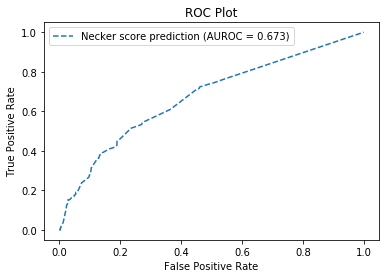

In [78]:
# Tracer la courbe pour NEM score

sklearn.metrics.roc_curve(y_test, y_prob_1)
r_auc = roc_auc_score(y_test, y_prob_1)
fpr, tpr, _ = roc_curve(y_test, y_prob_1)

plt.plot(fpr, tpr, linestyle='--', label='Necker score prediction (AUROC = %0.3f)' % r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [79]:
# En applicant les coef de l'IMPACT

df_impact = data[['IPP', 'DDK', 'COMPLICATION', 'RISK']]

In [80]:
# Pour avoir deux listes y_true et y_score et des valeures entre 0 et 1

df_impact.loc[:,'RISK'] = df_impact['RISK']

impact_true = df_impact['COMPLICATION'].to_list()
impact_true = list(map(bool,impact_true))
impact_score = df_impact['RISK'].to_list()

C:\Users\sophie\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [81]:
sklearn.metrics.roc_auc_score(impact_true, impact_score)
sklearn.metrics.roc_curve(impact_true, impact_score)
impact_r_auc = roc_auc_score(impact_true, impact_score)
impact_r_fpr, impact_r_tpr, _ = roc_curve(impact_true, impact_score)

In [82]:
impact_r_auc

0.6034346588476808

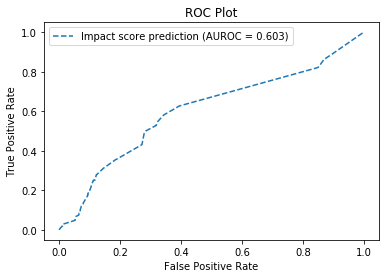

In [83]:
plt.plot(impact_r_fpr, impact_r_tpr, linestyle='--',
         label='Impact score prediction (AUROC = %0.3f)' % impact_r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Pour calculer des coefficients propres à notre cohorte

In [84]:
import statsmodels.api as sm

In [85]:
# définir la cible y et les variables explicatives x
y = data["COMPLICATION"].cat.codes

#  variables explicatives
x = data[['RISK_CAT1', 'RISK_CAT2', 'RISK_CAT3', 'RISK_CAT4', 'RISK_CAT5', 
           'RISK_CAT6',
           'VUL_HD',
           'IR',
           'VU',
           'COAG_DIS',
           'VUL_HD0',
           'VUL_HD1',
           'VUL_HD2',
           'VUL_HD3']]

In [86]:
# Obtenir la liste des coefficients atrtibués à chaque variable par la LR sur la cohorte NEM-KTTR

modele_logit = LogisticRegression(penalty='none',solver='newton-cg')
modele_logit.fit(x,y)

pd.DataFrame(np.concatenate([modele_logit.intercept_.reshape(-1,1),
                             modele_logit.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(x.columns)).T

,coef
constante,-1.077671
RISK_CAT1,-10.718923
RISK_CAT2,-0.660128
RISK_CAT3,0.424542
RISK_CAT4,0.019928
RISK_CAT5,0.220980
RISK_CAT6,-0.348546
VUL_HD,-3.822509
IR,1.039400
VU,0.856030
